In [24]:
from datetime import datetime, timedelta
import requests
import pandas
import time
today = datetime.now()
edt = time.mktime(today.timetuple())
sdt = time.mktime((today - timedelta(days = 360)).timetuple())
api_url = f'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start={sdt}&end={edt}&period=86400'
res = requests.get(api_url)
df = pandas.DataFrame(res.json())
df['date'] = pandas.to_datetime(df['date'], unit = 's')
df.head()


df.columns = ['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'QuoteVolume',
       'WeightedAverage']

df.head()

,Date,High,Low,Open,Close,Volume,QuoteVolume,WeightedAverage
0,2020-07-05 11:35:03,9074.000072,9074.000072,9074.000072,9074.000072,0.000000e+00,0.000000,9074.000072
1,2020-07-06 00:00:00,9372.800000,9058.235731,9071.944217,9344.659714,1.110820e+07,1202.890824,9234.587612
2,2020-07-07 00:00:00,9380.000000,9206.022576,9344.659714,9254.845314,8.239112e+06,888.809397,9269.830044
3,2020-07-08 00:00:00,9467.631957,9233.461684,9254.845314,9437.203866,1.269166e+07,1357.598009,9348.611356
4,2020-07-09 00:00:00,9440.000000,9170.000000,9437.203866,9239.350000,1.108406e+07,1191.039929,9306.206034


## 安裝 Backtesting 

! pip install backtesting

In [12]:
vars(Strategy)

mappingproxy({'__module__': 'backtesting.backtesting',
              '__doc__': '\n    A trading strategy base class. Extend this class and\n    override methods\n    `backtesting.backtesting.Strategy.init` and\n    `backtesting.backtesting.Strategy.next` to define\n    your own strategy.\n    ',
              '__init__': <function backtesting.backtesting.Strategy.__init__(self, broker, data, params)>,
              '__repr__': <function backtesting.backtesting.Strategy.__repr__(self)>,
              '__str__': <function backtesting.backtesting.Strategy.__str__(self)>,
              '_check_params': <function backtesting.backtesting.Strategy._check_params(self, params)>,
              'I': <function backtesting.backtesting.Strategy.I(self, func: Callable, *args, name=None, plot=True, overlay=None, color=None, scatter=False, **kwargs) -> numpy.ndarray>,
              'init': <function backtesting.backtesting.Strategy.init(self)>,
              'next': <function backtesting.backtesting.S

In [5]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA


class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 5) # 計算5日均綫
        self.ma2 = self.I(SMA, price, 20) #計算20日均綫 

    def next(self):
        if crossover(self.ma1, self.ma2): # 如果ma1突破ma2
            self.buy()
        elif crossover(self.ma2, self.ma1): # 如果ma2突破ma1
            self.sell()


bt = Backtest(df, SmaCross, commission=.002, cash = 100000, # commision 手續費， cash資金， exlusive order一次一筆交易
              exclusive_orders=True)
stats = bt.run()
bt.plot()

C:\Users\devil\.conda\envs\linebot\lib\site-packages\backtesting\_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

<ipython-input-5-fa7c522adf4d>:20: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, SmaCross, commission=.002, cash = 100000, # commision 手續費， cash資金， exlusive order一次一筆交易


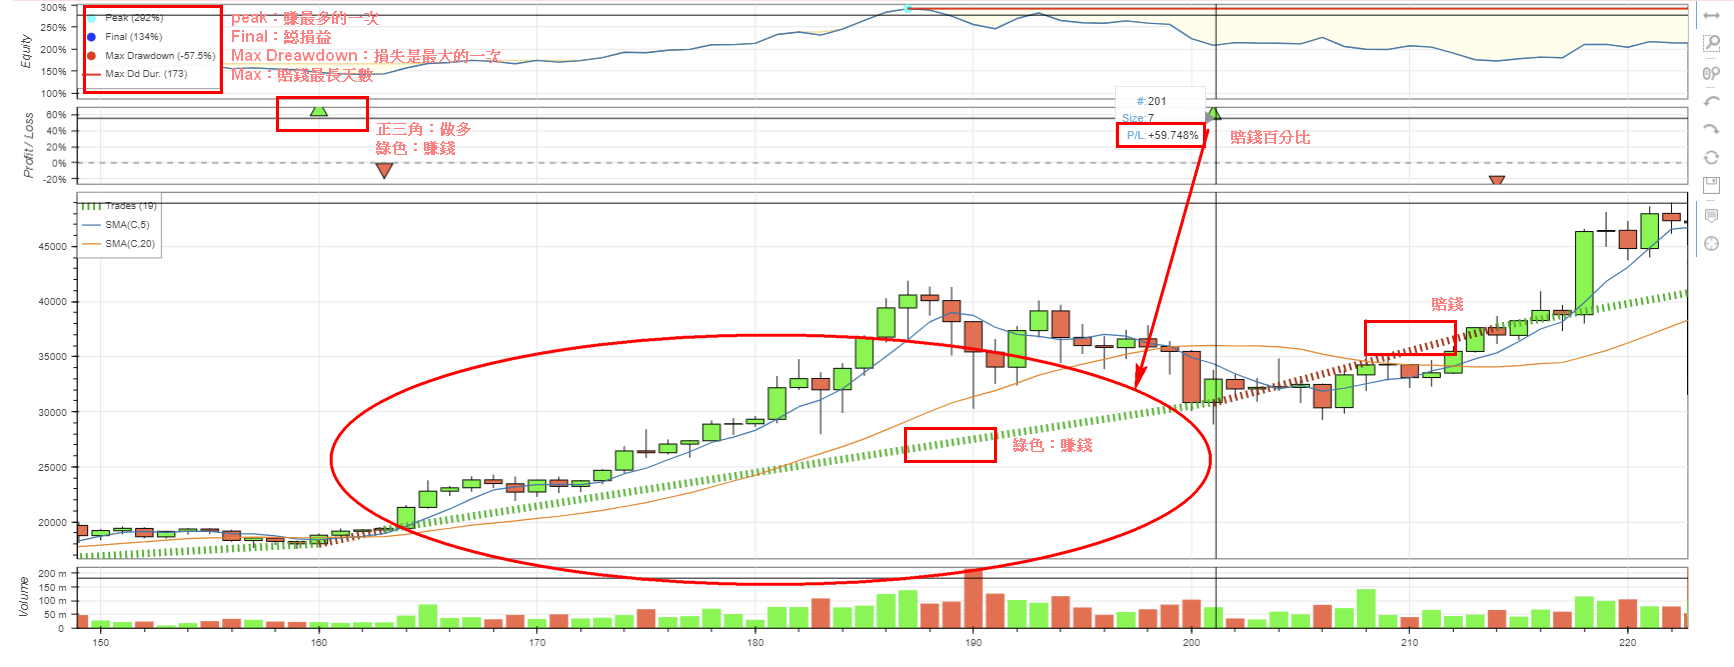

In [6]:
stats

Start                                     0.0
End                                     360.0
Duration                                360.0
Exposure Time [%]                   86.149584
Equity Final [$]                134228.299909
Equity Peak [$]                 292026.135653
Return [%]                            34.2283
Buy & Hold Return [%]              287.824585
Return (Ann.) [%]                         NaN
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                  -57.455075
Avg. Drawdown [%]                   -7.314699
Max. Drawdown Duration                  173.0
Avg. Drawdown Duration              17.058824
# Trades                                 19.0
Win Rate [%]                        26.315789
Best Trade [%]                      64.732303
Worst Trade [%]                    -22.224955
Avg. Trade [%]                    

In [9]:
class smacross_without_short(Strategy): # only buy
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 5)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            if len(self.trades) > 0: # 如果此時有單在倉内 强制平倉
                self.trades[0].close()


bt = Backtest(df, smacross_without_short, cash = 100000,
              exclusive_orders=True)
stats = bt.run()
bt.plot()

<ipython-input-9-1e3423a1bcba>:15: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, smacross_without_short, cash = 100000,


In [31]:
import talib # KD cross

class KDCross(Strategy):
    def init(self):
        
        self.slowk, self.slowd = self.I(talib.STOCH, self.data.High,self.data.Low,
                                            self.data.Close, fastk_period = 9,slowk_period=3,slowd_period=3)

    def next(self):
        if crossover(self.slowk, self.slowd):
            self.buy()
        elif crossover(self.slowd, self.slowk):
            self.sell()


bt = Backtest(df, KDCross, cash = 100000, exclusive_orders=True)
vars(Backtest)
# stats = bt.run()
# bt.plot()
help(Backtest)

Help on class Backtest in module backtesting.backtesting:

class Backtest(builtins.object)
 |  Backtest(data: pandas.core.frame.DataFrame, strategy: Type[backtesting.backtesting.Strategy], *, cash: float = 10000, commission: float = 0.0, margin: float = 1.0, trade_on_close=False, hedging=False, exclusive_orders=False)
 |  
 |  Backtest a particular (parameterized) strategy
 |  on particular data.
 |  
 |  Upon initialization, call method
 |  `backtesting.backtesting.Backtest.run` to run a backtest
 |  instance, or `backtesting.backtesting.Backtest.optimize` to
 |  optimize it.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data: pandas.core.frame.DataFrame, strategy: Type[backtesting.backtesting.Strategy], *, cash: float = 10000, commission: float = 0.0, margin: float = 1.0, trade_on_close=False, hedging=False, exclusive_orders=False)
 |      Initialize a backtest. Requires data and a strategy to test.
 |      
 |      `data` is a `pd.DataFrame` with columns:
 |      `Open`, `H

<ipython-input-31-ea74dc239fb5>:16: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, KDCross, cash = 100000, exclusive_orders=True)


In [17]:
Strategy.slowk, Strategy.slowd = Strategy.I(talib.STOCH, Strategy.data.High,Strategy.data.Low,
                                    Strategy.data.Close, fastk_period = 9,slowk_period=3,slowd_period=3)

AttributeError: 'property' object has no attribute 'High'